### Plot temperature and humidity data

In [3]:
from datetime import datetime
from datetime import timedelta
import numpy as np
data_N = 1 # smoothing factor for data reading
def read_data(file_path):
    trace = []
    with open(file_path, 'r') as f:
        # extract start time from start time
        first_line = f.readline()
        data = first_line.strip().split(',')
        start_time = datetime.strptime(data[0], '%H:%M:%S.%f')
        last_time = start_time
        negFlag = False # use a flag to avoid loops
        breakFlag = False

        while True:
            buf = []
            for i in range(0, data_N):
                line = f.readline()
                data = line.strip().split(',')
                cur_time = datetime.strptime(data[0], '%H:%M:%S.%f')
                # elapsed time in hours
                elapsed_time_h = (cur_time - start_time).total_seconds() / 3600
                
                if elapsed_time_h < 0:
                    # add another day to avoid negative elapsed time
                    negFlag = True
                    elapsed_time_h += 24
                elif negFlag == True and elapsed_time_h > 0:
                    # finish processing all the data, end the loop
                    breakFlag = True
                    break

                # process voltage, current and power data
                temp = int(data[5])
                humid = int(data[6])
                buf.append([elapsed_time_h, temp, humid])
                
            # use the average
            if len(buf) != 0: # buf is not empty
                buf = np.array(buf)
                trace.append(np.mean(buf, axis=0))
            
            if breakFlag:
                break
    return np.array(trace)

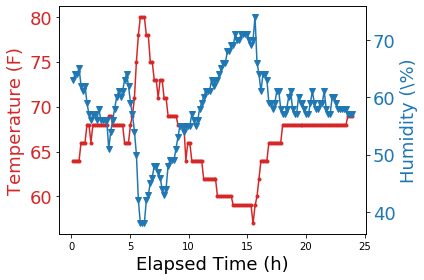

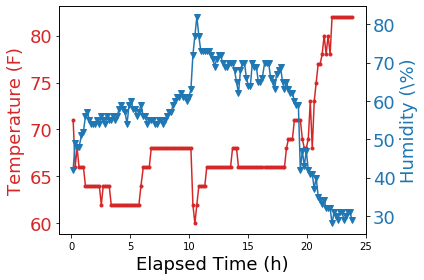

In [6]:
import matplotlib.pyplot as plt
def plot(trace, fname):
    fig, ax1 = plt.subplots()
    color = "tab:red"
    ax1.plot(trace[:, 0], trace[:, 1], color=color, marker='.')
    ax1.set_xlabel("Elapsed Time (h)", fontsize=18)
    ax1.set_ylabel("Temperature (F)", color=color, fontsize=18)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=18)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.plot(trace[:, 0], trace[:, 2], color=color, marker='v')
    ax2.set_ylabel('Humidity (\%)', color=color, fontsize=18)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=18)

    fig.tight_layout()

data_solar = read_data('./data/recv_data_solar.txt')
data_bat = read_data('./data/recv_data_bat.txt')

plot(data_solar, './img/solar.png')
plot(data_bat, './img/bat.png')